### Visualizing what convnets learn
#### Going further down the rabbit hole

* Visualizing intermediate convnet outputs (intermediate activations) - Useful for understanding successive convnet layers, and getting a first idea of meaning of convnet filters
* Visualizing Convnet filters - What visual pattern or concept each filter in a convnet is receptive to
* Visualizing heatmaps of class activation in an image

##### Visualizing intermediate activations

In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_______________________________________

In [2]:
img_path = r'C:\Users\pgbpr\Documents\Verusen\keras\dogs-vs-cats\small\test\cats\cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

(1, 150, 150, 3)


<Figure size 640x480 with 1 Axes>

In [3]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


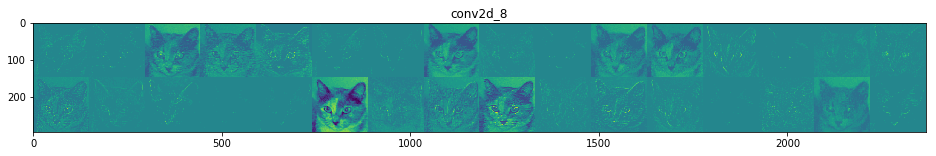

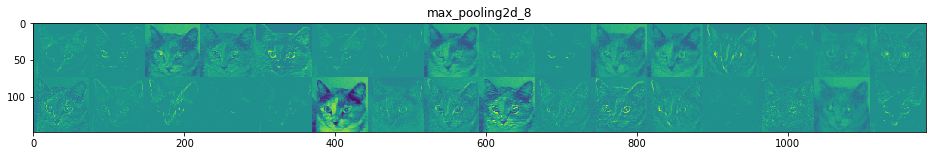

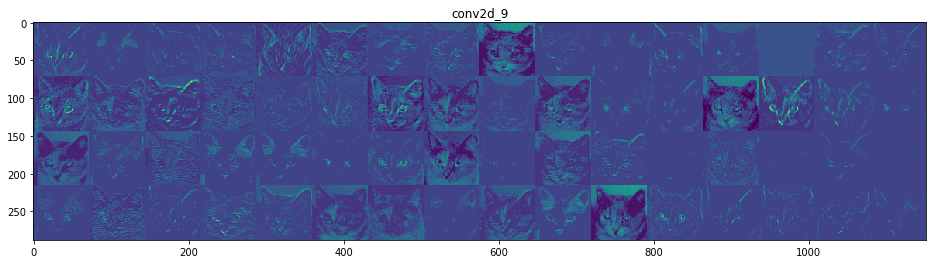

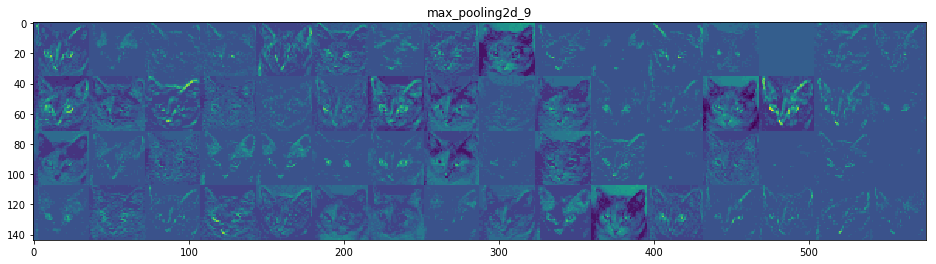

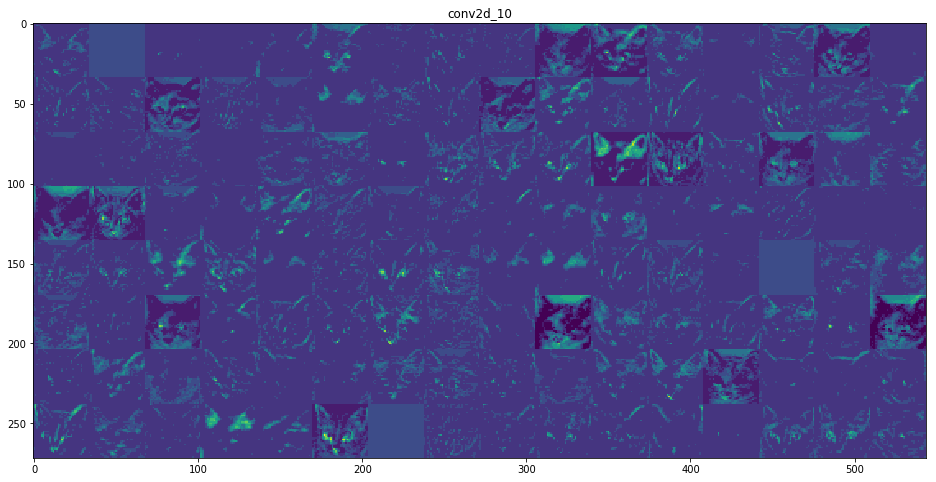

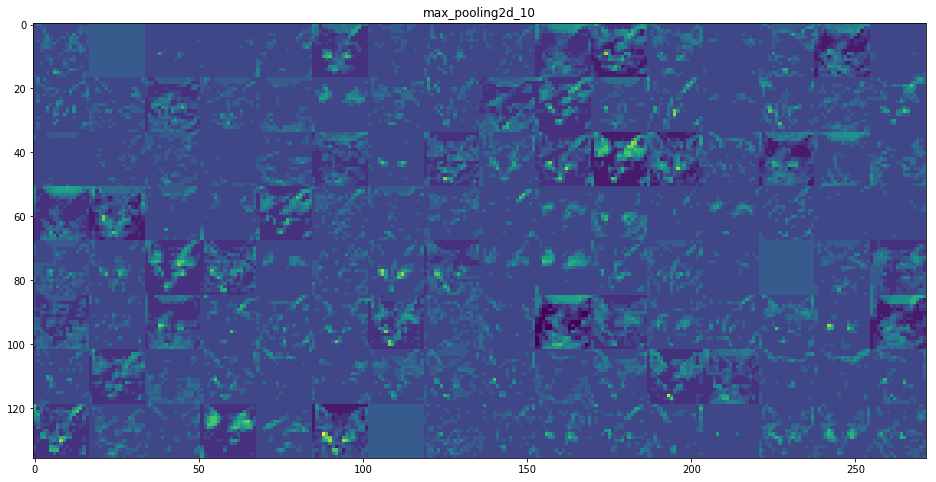

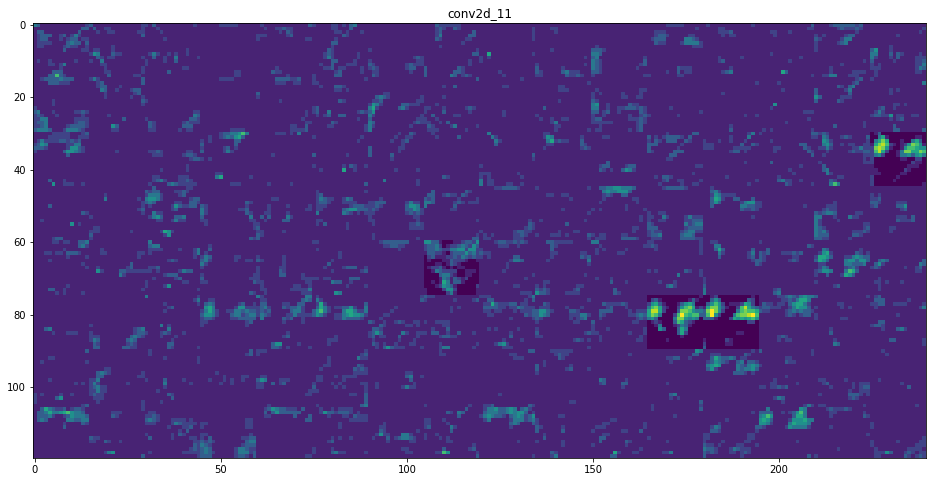

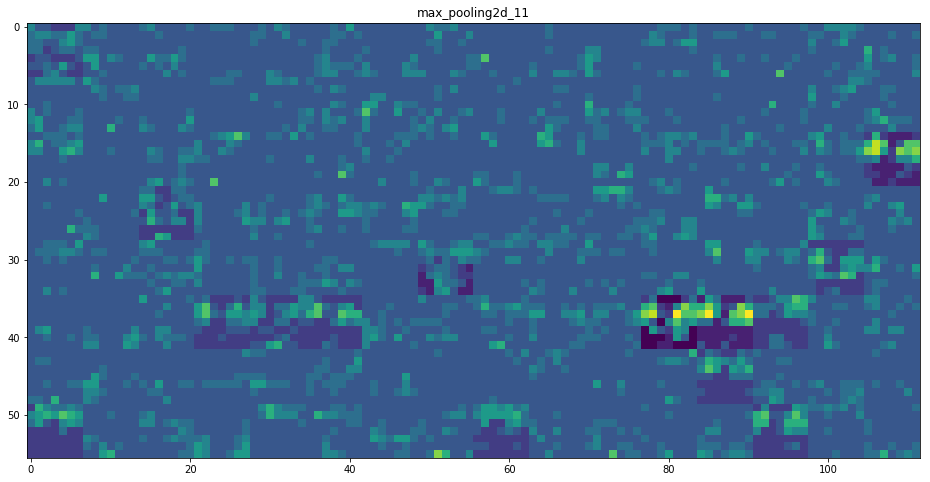

In [5]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Visualizing Convnet filters #2
Gradient Ascent in input space. 
Apply gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter.

In [ ]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]

grads /= (K.sqrt(K.mean(K.square(grades))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step
    
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x